In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('2.model_developing/model_mobileNet_apples.keras')


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2


In [9]:
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input, 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)

    # Debugging: Ausgabe der Heatmap
    plt.matshow(heatmap)
    plt.show()

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    cv2.imwrite(cam_path, superimposed_img)

    plt.imshow(superimposed_img[..., ::-1])  # cv2.imshow verwendet BGR statt RGB
    plt.axis('off')
    plt.show()





In [10]:
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input, 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Umwandlung in RGB für matplotlib

    # Debugging: Ausgabe der Heatmap
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)  # Umwandlung in RGB für matplotlib

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img_rgb)
    plt.title("Superimposed Image")
    plt.axis('off')

    plt.show()

    # Speichern des überlagerten Bildes
    cv2.imwrite(cam_path, superimposed_img)


In [21]:
img_path = 'D:/Uni Zeug/apple_blossom/ki_model/images/uploads/Bildschirmfoto 2024-06-04 um 17.02.01.png'
img_size = (224, 224)  # Größe an dein Modell anpassen
img_array = image.img_to_array(image.load_img(img_path, target_size=img_size))
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)
img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

preds = model.predict(img_array)
print("Predicted class:", np.argmax(preds[0]))


(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Predicted class: 2


In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, None, None, 32) │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, None, None, 64) │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, None, None, 64) │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, None, None,     │         8,192 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, None, None,     │         1,152 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 12,822,368 (48.91 MB)

 Trainable params: 4,266,826 (16.28 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 8,533,654 (32.55 MB)

In [37]:
for layer in model.layers:
    print(layer.name)


input_layer
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_pad_12
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_bn
con

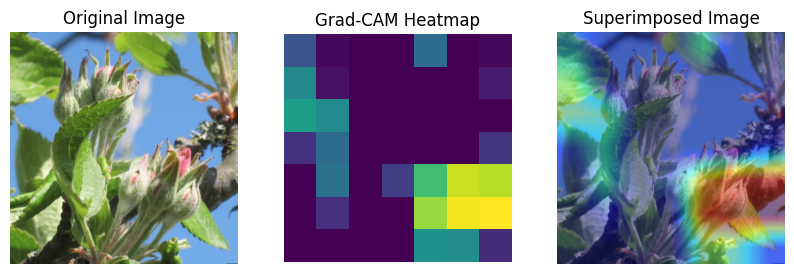

In [23]:
last_conv_layer_name = "conv_pw_13_relu"  # Name der letzten Convolutional Layer in deinem Modell
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)


In [24]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from typing import Any
import cv2

model = tf.keras.models.load_model("2.model_developing/model_mobileNet_apples.keras")

def get_img_array(img_path_gradcam:str, img_size_gradcam:tuple):
    """This function convert a image to a numpy array.
    Args:
        img_path_gradcam (str): path of the saved image
        img_size_gradcam (tuple): traget size in pixel

    Returns:
        img_array (np.array): converted image as array
    """
    img_array = image.img_to_array(image.load_img(img_path_gradcam, target_size=img_size_gradcam))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

    return img_array

def make_gradcam_heatmap(img_array:np.ndarray, model:Any, last_conv_layer_name:str, pred_index=None):
    """This function creates a np.ndarray for a grad cam image.

    Args:
        img_array (np.ndarray): converted image as array
        model (Any): keras model
        last_conv_layer_name (str): last layer in model
        pred_index (_type_, optional): set the pred_index to the highest predicted probability

    Returns:
        heatmap (np.ndarray): array
    """
    grad_model = tf.keras.models.Model(
        inputs=model.input, 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_gradcam(img_path:str, heatmap:np.ndarray, alpha=0.4):
    """This function save the grad cam image .

    Args:
        img_path (str): path to the input image
        heatmap (np.ndarray): grad cam array
        alpha (float, optional): percentage of transparency
    """
    img = cv2.imread(img_path)
    # Umwandlung in RGB für matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    # Debugging: Ausgabe der Heatmap
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    # Umwandlung in RGB für matplotlib
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)  

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img_rgb)
    plt.title("Superimposed Image")
    plt.axis('off')
    plt.show()



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


  1%|          | 10/1000 [00:00<00:55, 17.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  2%|▏         | 20/1000 [00:00<00:32, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  3%|▎         | 30/1000 [00:00<00:23, 40.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  4%|▍         | 40/1000 [00:01<00:20, 47.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  5%|▌         | 50/1000 [00:01<00:17, 53.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  6%|▌         | 60/1000 [00:01<00:16, 57.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  7%|▋         | 70/1000 [00:01<00:15, 60.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  8%|▊         | 80/1000 [00:01<00:14, 62.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  9%|▉         | 90/1000 [00:01<00:14, 63.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 10%|█         | 100/1000 [00:01<00:14, 63.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 11%|█         | 110/1000 [00:02<00:13, 64.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 12%|█▏        | 120/1000 [00:02<00:13, 65.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 13%|█▎        | 130/1000 [00:02<00:13, 65.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 14%|█▍        | 140/1000 [00:02<00:13, 63.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 15%|█▌        | 150/1000 [00:02<00:13, 64.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 16%|█▌        | 160/1000 [00:02<00:12, 65.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 17%|█▋        | 170/1000 [00:02<00:12, 65.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 18%|█▊        | 180/1000 [00:03<00:12, 65.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 19%|█▉        | 190/1000 [00:03<00:12, 66.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 20%|██        | 200/1000 [00:03<00:12, 65.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 21%|██        | 210/1000 [00:03<00:12, 64.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 22%|██▏       | 220/1000 [00:03<00:12, 63.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 23%|██▎       | 230/1000 [00:03<00:12, 63.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 24%|██▍       | 240/1000 [00:04<00:12, 62.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 25%|██▌       | 250/1000 [00:04<00:12, 62.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 26%|██▌       | 260/1000 [00:04<00:12, 60.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 27%|██▋       | 270/1000 [00:04<00:11, 61.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 28%|██▊       | 280/1000 [00:04<00:11, 61.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 29%|██▉       | 290/1000 [00:04<00:11, 62.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 30%|███       | 300/1000 [00:05<00:11, 63.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 31%|███       | 310/1000 [00:05<00:10, 64.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 32%|███▏      | 320/1000 [00:05<00:10, 64.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 33%|███▎      | 330/1000 [00:05<00:10, 65.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 34%|███▍      | 340/1000 [00:05<00:10, 65.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 65.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 64.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 37%|███▋      | 370/1000 [00:06<00:09, 65.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 38%|███▊      | 380/1000 [00:06<00:09, 65.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 39%|███▉      | 390/1000 [00:06<00:09, 65.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 40%|████      | 400/1000 [00:06<00:09, 64.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 41%|████      | 410/1000 [00:06<00:09, 65.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 42%|████▏     | 420/1000 [00:06<00:08, 65.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 43%|████▎     | 430/1000 [00:07<00:08, 65.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 44%|████▍     | 440/1000 [00:07<00:08, 66.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 45%|████▌     | 450/1000 [00:07<00:08, 66.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 46%|████▌     | 460/1000 [00:07<00:08, 66.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 47%|████▋     | 470/1000 [00:07<00:07, 66.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 48%|████▊     | 480/1000 [00:07<00:07, 66.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 66.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 50%|█████     | 500/1000 [00:08<00:07, 66.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 51%|█████     | 510/1000 [00:08<00:07, 66.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 52%|█████▏    | 520/1000 [00:08<00:07, 66.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 53%|█████▎    | 530/1000 [00:08<00:07, 66.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 54%|█████▍    | 540/1000 [00:08<00:06, 66.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 55%|█████▌    | 550/1000 [00:08<00:06, 64.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 56%|█████▌    | 560/1000 [00:09<00:06, 64.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 57%|█████▋    | 570/1000 [00:09<00:06, 65.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 58%|█████▊    | 580/1000 [00:09<00:06, 65.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 59%|█████▉    | 590/1000 [00:09<00:06, 66.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 60%|██████    | 600/1000 [00:09<00:06, 66.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 61%|██████    | 610/1000 [00:09<00:05, 66.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 66.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 63%|██████▎   | 630/1000 [00:10<00:05, 66.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 64%|██████▍   | 640/1000 [00:10<00:05, 66.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 65%|██████▌   | 650/1000 [00:10<00:05, 66.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 66%|██████▌   | 660/1000 [00:10<00:05, 66.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 67%|██████▋   | 670/1000 [00:10<00:04, 66.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 68%|██████▊   | 680/1000 [00:10<00:04, 66.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 64.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 70%|███████   | 700/1000 [00:11<00:04, 65.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 71%|███████   | 710/1000 [00:11<00:04, 65.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 72%|███████▏  | 720/1000 [00:11<00:04, 65.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 73%|███████▎  | 730/1000 [00:11<00:04, 65.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 74%|███████▍  | 740/1000 [00:11<00:03, 66.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 75%|███████▌  | 750/1000 [00:11<00:03, 67.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 76%|███████▌  | 760/1000 [00:12<00:03, 66.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 77%|███████▋  | 770/1000 [00:12<00:03, 66.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 78%|███████▊  | 780/1000 [00:12<00:03, 66.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 79%|███████▉  | 790/1000 [00:12<00:03, 66.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 80%|████████  | 800/1000 [00:12<00:02, 66.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 81%|████████  | 810/1000 [00:12<00:02, 66.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 82%|████████▏ | 820/1000 [00:12<00:02, 64.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 83%|████████▎ | 830/1000 [00:13<00:02, 65.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 84%|████████▍ | 840/1000 [00:13<00:02, 65.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 85%|████████▌ | 850/1000 [00:13<00:02, 65.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 86%|████████▌ | 860/1000 [00:13<00:02, 65.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 87%|████████▋ | 870/1000 [00:13<00:01, 65.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 88%|████████▊ | 880/1000 [00:13<00:01, 66.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 89%|████████▉ | 890/1000 [00:14<00:01, 65.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 90%|█████████ | 900/1000 [00:14<00:01, 65.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 91%|█████████ | 910/1000 [00:14<00:01, 66.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 92%|█████████▏| 920/1000 [00:14<00:01, 66.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 93%|█████████▎| 930/1000 [00:14<00:01, 66.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 94%|█████████▍| 940/1000 [00:14<00:00, 66.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 95%|█████████▌| 950/1000 [00:14<00:00, 64.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 96%|█████████▌| 960/1000 [00:15<00:00, 65.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 97%|█████████▋| 970/1000 [00:15<00:00, 65.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 98%|█████████▊| 980/1000 [00:15<00:00, 66.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 99%|█████████▉| 990/1000 [00:15<00:00, 66.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


100%|██████████| 1000/1000 [00:15<00:00, 63.85it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9058823585510254..1.0].


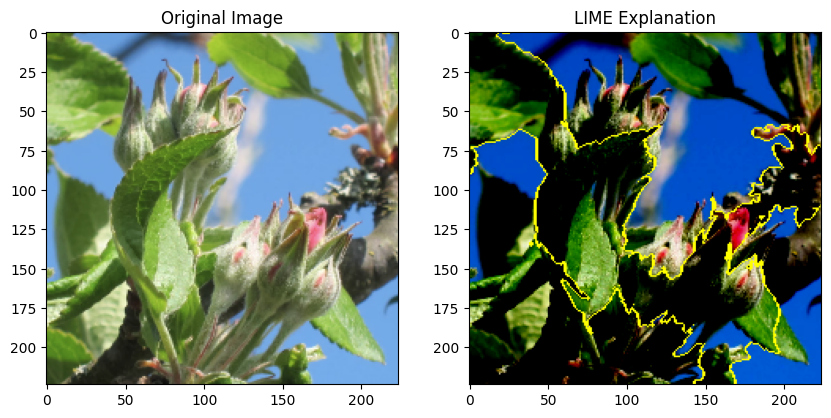

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Laden des Modells (ersetzen Sie 'model' durch Ihr tatsächliches Modell)
# model = ...

# Bildpfad
img_path = 'D:/Uni Zeug/apple_blossom/ki_model/images/uploads/Bildschirmfoto 2024-06-04 um 17.02.01.png'
img_size = (224, 224)

# Bild laden und vorbereiten
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

# LIME Erklärung erzeugen
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_array[0].astype('double'), 
    model.predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=1000
)

# Darstellung der LIME Erklärung
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=10, 
    hide_rest=False
)

plt.figure(figsize=(10, 5))

# Originalbild
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# LIME Bild
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title('LIME Explanation')

plt.show()


SHAP mit 32x32 Auflösung

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: 2


PartitionExplainer explainer: 2it [01:19, 79.15s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.99215686].


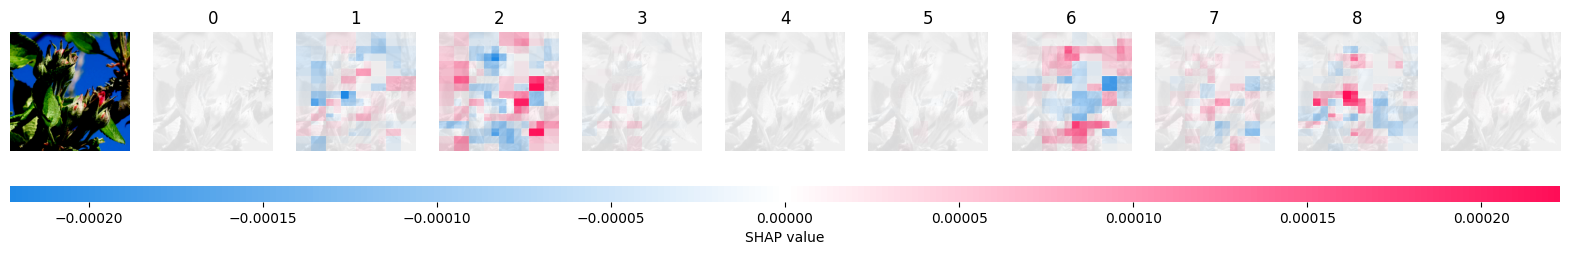

In [8]:
import tensorflow as tf
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Laden des trainierten Modells

# Laden und Vorverarbeiten des Bildes
img_path = 'D:/Uni Zeug/apple_blossom/ki_model/images/uploads/Bildschirmfoto 2024-06-04 um 17.02.01.png'
img_size = (224, 224)
img_array = image.img_to_array(image.load_img(img_path, target_size=img_size))
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

# Vorhersage für das Bild (zum Testen)
preds = model.predict(img_array)
print("Predicted class:", np.argmax(preds[0]))

# Definieren der Vorhersagefunktion
def f(x):
    tmp = x.copy()
    return model(tmp)

# Erstellen des SHAP Explainers mit Maskierung
masker_blur = shap.maskers.Image("blur(32,32)", img_array[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(10)))

# Berechnen und Visualisieren der SHAP Werte
ind = [0]  # Index des zu erklärenden Bildes
shap_values_ = explainer(img_array[ind], max_evals=5000, batch_size=50)
shap.image_plot(shap_values_, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Alternative Methode mit DeepExplainer und Hintergrunddaten
# Hier Beispielcode: Verwenden Sie eine repräsentative Stichprobe aus Ihren Trainingsdaten
# background = np.random.random(img_array.shape) # Hier sollten Sie Ihre echten Hintergrunddaten verwenden
# e = shap.DeepExplainer(model, background)
# shap_values = e.shap_values(img_array[ind])
# shap.image_plot(shap_values, img_array[ind])


SHAP mit 64x64 Auflösung

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: 2


PartitionExplainer explainer: 2it [01:20, 80.80s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.99215686].


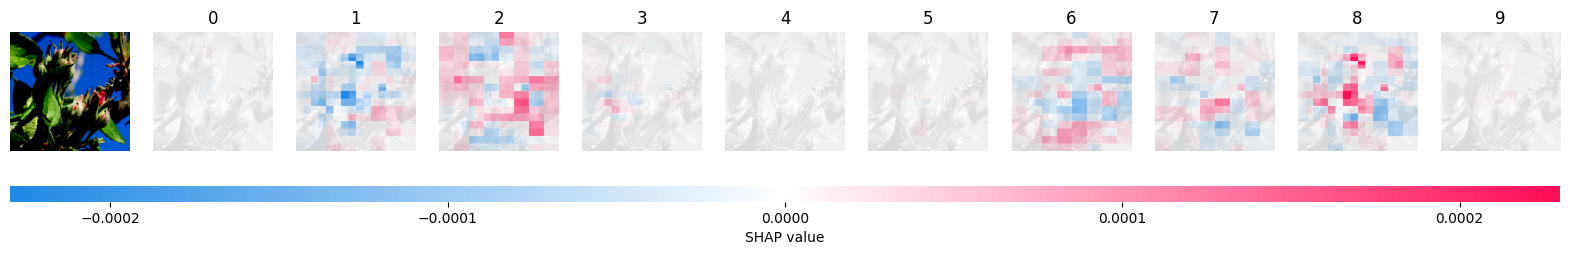

In [9]:
import tensorflow as tf
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Laden des trainierten Modells

# Laden und Vorverarbeiten des Bildes
img_path = 'D:/Uni Zeug/apple_blossom/ki_model/images/uploads/Bildschirmfoto 2024-06-04 um 17.02.01.png'
img_size = (224, 224)
img_array = image.img_to_array(image.load_img(img_path, target_size=img_size))
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

# Vorhersage für das Bild (zum Testen)
preds = model.predict(img_array)
print("Predicted class:", np.argmax(preds[0]))

# Definieren der Vorhersagefunktion
def f(x):
    tmp = x.copy()
    return model(tmp)

# Erstellen des SHAP Explainers mit Maskierung
masker_blur = shap.maskers.Image("blur(64,64)", img_array[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(10)))

# Berechnen und Visualisieren der SHAP Werte
ind = [0]  # Index des zu erklärenden Bildes
shap_values_ = explainer(img_array[ind], max_evals=5000, batch_size=50)
shap.image_plot(shap_values_, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Alternative Methode mit DeepExplainer und Hintergrunddaten
# Hier Beispielcode: Verwenden Sie eine repräsentative Stichprobe aus Ihren Trainingsdaten
# background = np.random.random(img_array.shape) # Hier sollten Sie Ihre echten Hintergrunddaten verwenden
# e = shap.DeepExplainer(model, background)
# shap_values = e.shap_values(img_array[ind])
# shap.image_plot(shap_values, img_array[ind])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: 2


PartitionExplainer explainer: 2it [02:37, 157.81s/it]              
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.99215686].


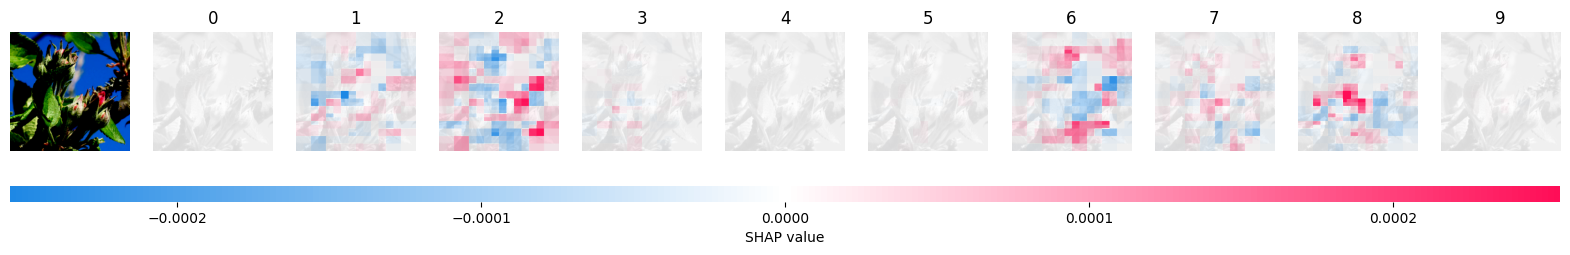

In [12]:
import tensorflow as tf
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Laden des trainierten Modells

# Laden und Vorverarbeiten des Bildes
img_path = 'D:/Uni Zeug/apple_blossom/ki_model/images/uploads/Bildschirmfoto 2024-06-04 um 17.02.01.png'
img_size = (224, 224)
img_array = image.img_to_array(image.load_img(img_path, target_size=img_size))
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)

# Vorhersage für das Bild (zum Testen)
preds = model.predict(img_array)
print("Predicted class:", np.argmax(preds[0]))

# Definieren der Vorhersagefunktion
def f(x):
    tmp = x.copy()
    return model(tmp)

# Erstellen des SHAP Explainers mit Maskierung
masker_blur = shap.maskers.Image("blur(32,32)", img_array[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(10)))

# Berechnen und Visualisieren der SHAP Werte
ind = [0]  # Index des zu erklärenden Bildes
shap_values_ = explainer(img_array[ind], max_evals=10000, batch_size=50)
shap.image_plot(shap_values_, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Alternative Methode mit DeepExplainer und Hintergrunddaten
# Hier Beispielcode: Verwenden Sie eine repräsentative Stichprobe aus Ihren Trainingsdaten
# background = np.random.random(img_array.shape) # Hier sollten Sie Ihre echten Hintergrunddaten verwenden
# e = shap.DeepExplainer(model, background)
# shap_values = e.shap_values(img_array[ind])
# shap.image_plot(shap_values, img_array[ind])